In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import thinkstats2
import thinkplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split

# Assignment 4 - Classification

For this assignment, you'll need to perform a classification on a dataset, as well as do some prep work on the data. 

The exact steps of what you need to do are flexible and up to you to some degree, however you should consider some of the important things we've mentioned recently, such as:
<ul>
<li> Is the target balanced?
<li> Are there missing or erroneous values?
<li> Are there categorical or numerical features?
<li> Is there colinearity?
<li> Are there outliers?
<li> Should we normalize? 
<li> Do the distributions of the features give any indication that some may need work? 
</ul>

Basically, the data is in the original, potentially dirty, format, and you need to find what should be cleaned, and do the cleaning. There is not one "right" answer to what has to be done, and you'll probably need to do it with at least something of an iterative process - find an issue, correct it, check the data, repeat.

<b>The target that we are predicting is the loan_status. </b>

## Grading

The grades will be broken down as follows:
<ul>
<li> <b>30%</b> - a working predictive model with a reasonable level of accuracy. 
    <ul>
    <li> For the accuracy part, it will not be explicitly graded, but compared to all the others. If you're in the same general range, that's good - if yours is drastically less accurate (or, I guess more accurate), then I'll adjust. There won't be a comparison of "this person is 72.3% and this person is only 71.8% accurate, they fail."
    <li> This data is larger than most of the small sample sets, so random variations due to train-test splits shouldn't be too bad. (If you're a keener you could loop)
    <li> I will use the F1 score as the accuracy metric. 
    </ul>
<li> <b>40%</b> - a clear and readable description of what steps you took to prepare the data, and a brief not on the rationale behind it. Did you do a log transformation to a skewed feature, did you remove outliers, did you remove a feature that has a lot of missing values? Please put this somewhere obvious and readable, consider the goal of the assignment to explain your process to me. 
    <ul>
    <li> E.g. "The target data was imbalanced, so I tried several resampling methods and chose the one with the highest accuracy of the resulting model", "the feature X had the same value for 95% of records, so I dropped it". 
    <li> In this, please also state if you see a group that appears to be a good credit risk, and a group that is a bad credit risk, and indicate the evidence showing that. Please do this other than the most simplistic way - more money = better credit. If there are no such groups, state why you think this. This will likely be about 3 - 5 statements or points, you should provide evidence from the data, but it does not need to be an essay. (You may want to consider this question after you're pretty much done with the data prep and modelling.)
    </ul>
<li> <b>30%</b> - allowing your model to be "deployed". At the bottom of this file there is a small block of code to load in some test data (that I have), and calculate your accuracy. Your contribution to this part is to have a model that is ready to make predictions. Some specifics to consider:
    <ul>
    <li> The test data will be in exactly the same format as the dataset you're given. So any steps that you took to prepare your data for modelling will need to be mirroed here, so the new  data can be predicted. The easiest way to do this is to use a pipeline, but it is up to you. Remember the model only accepts data that is in a certain format - the one that you had the data in when it was trained, so when making predictions you need to make sure that is true. 
    <li> Since I'm providing test data, and your task is to just create a model, think about how that might impact your train-test splitting, both as you're developing and for the final product. 
    <li> Once the model is trained it should predict any data that is in the right format, so I should be able to provide any proper dataset, click run on that testing cell, and get predictions. I will not be doing anything that will purposefully make this harder or trickier, like including data that has errors or is in the wrong format, I just split the entire set of data, reserved part of it to test accuracy, and gave the rest to you. Things that you've changed (e.g. dropping a column, one-hot encoding) do need to be replicated at some point before the model can accept the new data to predict. In general we <b>do</b> want to check in our processing that our input is valid, this is kind of a junior introduction to that. 
    </ul>
</ul

## Load Credit Data

In [2]:
df = pd.read_csv("train.csv")
df.head()

,Unnamed: 0,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,26967,27,120000,MORTGAGE,3.0,PERSONAL,B,14000,11.99,0,0.12,N,10
1,8449,24,58000,MORTGAGE,8.0,DEBTCONSOLIDATION,A,15700,7.90,0,0.27,N,3
2,20983,30,45000,RENT,11.0,MEDICAL,C,5000,12.73,1,0.11,Y,8
3,19612,35,35000,MORTGAGE,5.0,EDUCATION,B,5600,11.49,0,0.16,N,6
4,30371,38,55000,RENT,0.0,EDUCATION,C,6500,11.03,0,0.12,Y,12


### Accuracy Test

Replace the green part with whatever you need to transform the fresh data into the format needed for your model to predict. 

<b>Note:</b> you could test and make sure that things are working OK here by taking part of your dataset, saving it in a separate CSV, and running it through here as a piece of test data. The accuracy results would be useless, but you'd confirm that the model works properly. 

In [6]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import binarize

# 1. Load Data
df = pd.read_csv("train.csv")

# Drop the unnamed index column if present (common issue)
if df.columns[0].startswith('Unnamed'):
    df = df.iloc[:, 1:]

# 2. Handle Missing Values and Outliers
df_cleaned = df.dropna()
df_cleaned = df_cleaned[df_cleaned['person_age'] < 90]
df_cleaned = df_cleaned[df_cleaned['person_emp_length'] < 60]
df_cleaned = df_cleaned[df_cleaned['person_income'] < 1000000]

# --- CRITICAL STEP: Reset index after filtering to prevent index alignment errors ---
df_cleaned.reset_index(drop=True, inplace=True)

# 3. Feature Engineering
# Explicitly cast boolean result to int (0 or 1)
df_cleaned["grade_2"] = df_cleaned["loan_grade"].isin(["A", "B", "C"]).astype(int) 
df_cleaned.drop(columns={"loan_grade"}, inplace=True)

# 4. One-Hot Encode Categorical Features
categorical_cols = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
df_features = pd.get_dummies(df_cleaned.drop(columns=['loan_status']), columns=categorical_cols, drop_first=True, dtype=int)
y = df_cleaned['loan_status']
X = df_features

# 5. Ensure all feature columns are numeric float for consistency
X = X.astype(np.float64)

# 6. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
numerical_cols = [
    'person_age', 'person_income', 'person_emp_length', 
    'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
    'cb_person_cred_hist_length'
]

non_numerical_cols = [col for col in X_train.columns if col not in numerical_cols]
scaler = StandardScaler()

# 1. Transform Training Data
X_train_num_scaled = pd.DataFrame(
    scaler.fit_transform(X_train[numerical_cols]), 
    columns=numerical_cols, 
    index=X_train.index
)
X_train_scaled = pd.concat([X_train_num_scaled, X_train[non_numerical_cols]], axis=1)
X_train_final_cols = X_train_scaled.columns # Capture final order

# 2. Transform Test Data
X_test_num_scaled = pd.DataFrame(
    scaler.transform(X_test[numerical_cols]), 
    columns=numerical_cols, 
    index=X_test.index
)
X_test_scaled = pd.concat([X_test_num_scaled, X_test[non_numerical_cols]], axis=1)

# Explicitly reindex the test set to match the training set order (CRITICAL FIX)
X_test_scaled = X_test_scaled.reindex(columns=X_train_final_cols, fill_value=0)


# 8. Model Training
# The final model must be named 'model'
model = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# 9. Model Evaluation (Self-Assessment)
prediction_labels = model.predict(X_test_scaled)
f1 = f1_score(y_test, prediction_labels)
conf_matrix = confusion_matrix(y_test, prediction_labels)

print(f"Model F1 Score on Test Set: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Model F1 Score on Test Set: 0.6496
Confusion Matrix:
[[2971  622]
 [ 214  775]]


In [ ]:
# Get the column order established in Cell 3
X_train_final_cols = X_train_scaled.columns

# Helper function to replicate the exact data preparation steps
def preprocess_for_prediction(data_frame, scaler, numerical_features, X_train_final_cols):
    # 1. Data Cleaning and Feature Engineering (replication of Cell 2)
    data_frame_cleaned = data_frame.copy()
    
    if data_frame_cleaned.columns[0].startswith('Unnamed'):
        data_frame_cleaned = data_frame_cleaned.iloc[:, 1:]
        
    data_frame_cleaned.dropna(inplace=True) 
    data_frame_cleaned.reset_index(drop=True, inplace=True) # Index Reset

    data_frame_cleaned = data_frame_cleaned[data_frame_cleaned['person_age'] < 90]
    data_frame_cleaned = data_frame_cleaned[data_frame_cleaned['person_emp_length'] < 60]
    data_frame_cleaned = data_frame_cleaned[data_frame_cleaned['person_income'] < 1000000]

    data_frame_cleaned["grade_2"] = data_frame_cleaned["loan_grade"].isin(["A", "B", "C"]).astype(int)
    data_frame_cleaned.drop(columns={"loan_grade"}, inplace=True, errors='ignore')

    # Separate features and target
    y_out = data_frame_cleaned['loan_status'] if 'loan_status' in data_frame_cleaned.columns else None
    X_out = data_frame_cleaned.drop(columns=['loan_status'], errors='ignore')

    # 2. One-Hot Encode Categorical Features
    categorical_cols = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
    X_out = pd.get_dummies(X_out, columns=categorical_cols, drop_first=True, dtype=int)
    
    # 3. Align columns (CRITICAL STEP for deployment)
    X_out = X_out.reindex(columns=X_train_final_cols, fill_value=0)

    # 4. Scaling numerical features
    non_numerical_features = [col for col in X_train_final_cols if col not in numerical_features]
    
    X_out_num_scaled = pd.DataFrame(
        scaler.transform(X_out[numerical_features]), 
        columns=numerical_features, 
        index=X_out.index
    )
    X_out_scaled = pd.concat([X_out_num_scaled, X_out[non_numerical_features]], axis=1)

    # Ensure consistent float data type
    X_out_scaled = X_out_scaled.astype(np.float64)
    
    return X_out_scaled, y_out



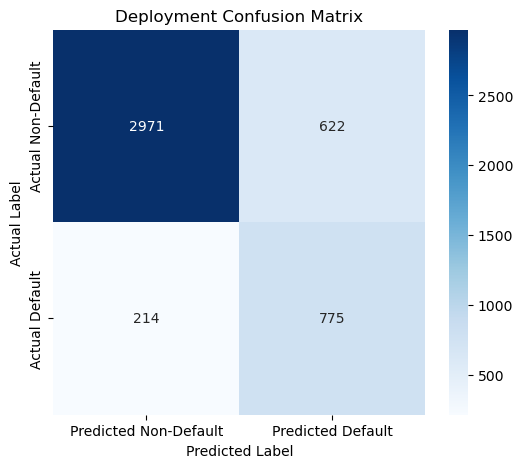

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the confusion matrix from the deployment step is stored in 'conf_matrix'
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['Predicted Non-Default', 'Predicted Default'],
    yticklabels=['Actual Non-Default', 'Actual Default']
)
plt.title('Deployment Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()